In [1]:
#imports
from matplotlib import pyplot as plt
from scipy.stats import entropy
import numpy as np
import torch
import sys
import glob
sys.path.insert(0, '..')
from models import Classifier
from losses import WeightedMSE, FlatLoss, Disco
from utils import Metrics, find_threshold, DataSet, Logger
from utils import LegendreFitter, LegendreIntegral
from torch.autograd import gradcheck
torch.manual_seed(72)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print('device used in training:', device)

device used in training: cuda:0


In [2]:
def metric_calc(model,X,y,x_biased,metric=None):
    predictions = np.array(model(X).tolist()).flatten()
    if metric is None:
        metrics_test = Metrics(validation=True) 
    else:
        metrics_test = metric(validation=True) 
    metrics_test.calculate(pred=predictions, target=y,m=x_biased)
    R50 = metrics_test.R50[0]
    JSD = metrics_test.JSD[0]
    return (1/JSD,R50)
class Metrics2():
    def __init__(self,validation=False):
        self.validation = validation
        self.losses = []
        self.accs = []
        self.signalE = []
        self.backgroundE= []
        if self.validation:
            self.R50 = []
            self.JSD = []
    def calculate(self,pred,target,l=None,m=None):
        preds = np.array(pred.tolist()).flatten()
        targets = np.array(target.tolist()).flatten()
        acc = (preds.round()==targets).sum()/targets.shape[0]
        signal_efficiency = ((preds.round()==targets)&(targets==1)).sum()/(targets==1).sum()
        background_efficiency = ((preds.round()==targets)&(targets==0)).sum()/(targets==0).sum()


        if self.validation:
            c = find_threshold(preds,(targets==0),0.5)
            R50 = 1/((preds[targets==1]<c).sum()/(targets==1).sum())
            self.R50.append(R50)
            if m is not None:
                m = np.array(m.tolist()).flatten()
                hist1, bins = np.histogram(m[targets==1],bins=50,density=True,range=[50,300])
                hist2, _ = np.histogram(m[(targets==1)&(preds<c)],bins=50,density=True,range=[50,300])
                JSD = 0.5*(entropy(hist1,0.5*(hist1+hist2),base=2)+entropy(hist2,0.5*(hist1+hist2),base=2))#*(bins[1]-bins[0])
                self.JSD.append(JSD)
        self.accs.append(acc)
        self.signalE.append(signal_efficiency)
        self.backgroundE.append(background_efficiency)
        if l:
            self.losses.append(l)
def plot_stuff(model,X,y,x_biased,mbins=100,histbins=None,name='Naive DNN',f=None,ptype=0,dynamicbins=True,scale=None):
    if histbins == None:
        histbins=mbins
    predictions = np.array(model(X).tolist()).flatten()
    metrics_test = Metrics(validation=True) 
    metrics_test.calculate(pred=predictions, target=y,m=x_biased)
    R50 = metrics_test.R50[0]
    JSD = metrics_test.JSD[0]
    
    
    c = find_threshold(predictions,(y==0),0.5)
    fig, [ax,ax1] = plt.subplots(2,1,figsize=(6,8),dpi=120,sharex=True)
    _,bins,_ = ax.hist(x_biased[(y==1)],bins=histbins,alpha=0.3,color='C1',label='Background',density=True,log=True)
    ax.hist(x_biased[(y==1)&(predictions<c)],bins=bins,alpha=0.3,color='C0',label='False Positives',density=True,log=True)
    ax.set_ylabel("Normed Counts",fontsize=14)
    ax.set_title('{} (R50:{:.2f}, 1/JSD:{:.2f})'.format(name,R50,1/JSD))
    ax.legend()

    efficiencies = np.linspace(0.1,0.9,9)
    cuts = []
    for eff in efficiencies:
        cuts.append(find_threshold(predictions,(y==0),eff))
    m = x_biased[y==1]
    scores = predictions[y==1]
    if dynamicbins:
        sorted_m = np.argsort(m)
        scores = scores[sorted_m].reshape(mbins,-1)
        m = m[sorted_m]
        m = m.reshape(mbins,-1).mean(axis=1)
    else:
        _,bins = np.histogram(m,bins=mbins)
        digitized = np.digitize(m,bins)
        m = bins[:-1]
    for j,cut in enumerate(cuts):
        c = f"C{j}" #if j!= 6 else f"C11"
        if dynamicbins:
            passed = (scores<cut).sum(axis=1)/scores.shape[1]
        else:
            passed = [(scores[digitized==i]<cut).sum()/(digitized==i).sum() for i in range(mbins)]
        if ptype == 0:
            ax1.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)
        else:
            ax1.step(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)
    if scale is not None:
        ax1.set_yscale(scale)        
    ax1.set_ylabel("False Pos. Rate",fontsize=14)
    ax1.set_ylim([-0.02,1.02])
    ax1.legend(loc='upper right', bbox_to_anchor=(1,1) ,markerscale=5,title="SE (Cut)",ncol=3)
    ax1.set_xlabel(r"$m$",fontsize=14)
    fig.tight_layout(pad=0)
    if f is not None:
        fig.savefig(f)
    plt.show()
    return (1/JSD,R50)
class Model(Classifier):
    def __init__(self,input_size=10,name=None):
        """
         DNN Model inherits from torch.torch.nn.Module. Can be initialized with input_size: Number of features per sample.

        This is a class wrapper for a simple DNN model. Creates an instance of torch.torch.nn.Module that has 4 linear layers. Use torchsummary for details.abs

        Parameters
        ----------
        input_size : int=10
            The number of features to train on.
        name : string=None
            Specifiy a name for the Dtorch.nn.break
        """
        super(Classifier,self).__init__()
        self.linear = torch.nn.Linear(input_size,64)
        self.linear1 = torch.nn.Linear(64,64,)
        self.linear2 = torch.nn.Linear(64,64)
        self.linear3 = torch.nn.Linear(64,64)
        self.batchnorm = torch.nn.BatchNorm1d(64)
        self.out = torch.nn.Linear(64,1)
        # Defaults
        self.optimizer = torch.optim.SGD(self.parameters(),lr=1e-3)
        self.yhat_val = None
        self.yhat = None
        self.name = name
    def forward(self, x):
        x = torch.nn.functional.relu(self.linear(x))
#         x = torch.nn.functional.relu(self.linear1(x))
        x = torch.nn.functional.relu(self.linear1(x))
        x = torch.nn.functional.relu(self.linear2(x))
        x = self.batchnorm(x)
        x = torch.nn.functional.relu(self.linear3(x))
        x = torch.sigmoid(self.out(x))
        return x
class ReduceLROnPlateau(torch.optim.lr_scheduler.ReduceLROnPlateau):
    def __repr__(self):
        keys = ['patience','factor', 'min_lr', 'cooldown', 
                'mode', 'threshold', 'threshold_mode', 'verbose']
        values = [self.patience, self.factor, self.min_lrs,  
                  self.cooldown, self.mode, self.threshold, 
                self.threshold_mode,self.verbose]
        string = self.__class__.__name__ +"(\n"
        for key,value in zip(keys,values):
            string += f"     {key}: {value}\n"
        string += ')'
        return string
class MultiStepLR(torch.optim.lr_scheduler.MultiStepLR):
    def __repr__(self):
        keys = ['milestones','gamma']
        values = [self.milestones, self.gamma]
        string = self.__class__.__name__ +"(\n"
        for key,value in zip(keys,values):
            string += f"     {key}: {value}\n"
        string += ')'
        return string

In [3]:
path = "./logs/architectures/FinalCalcPt/"

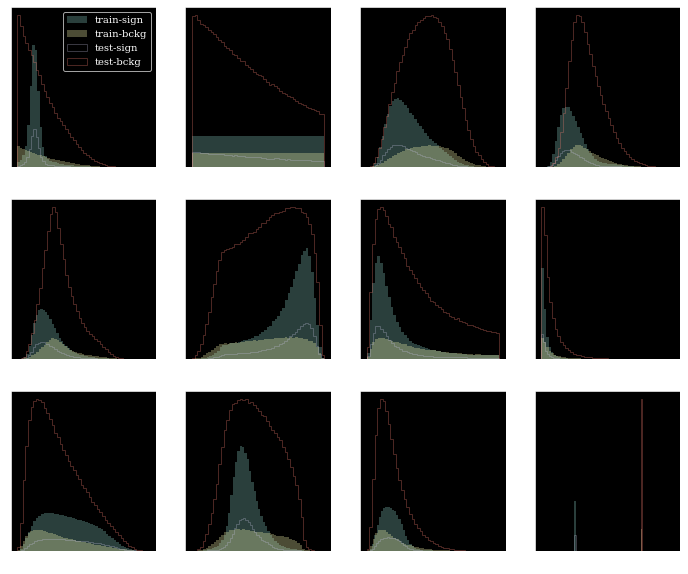

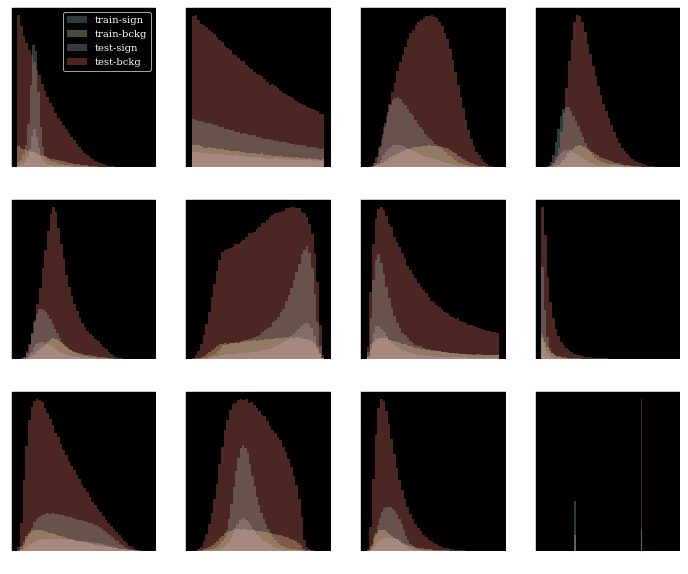

In [4]:
#dataset 
files = np.load("data/W_FCN_v0.npz")
train = files["train"].astype('float32')
val = files["val"].astype('float32')
test = files["test"].astype('float32')

train_labels = train[::,-1]
val_labels   = val[::,-1]
test_labels=test[::,-1]

data = np.concatenate([train,val,test],axis=0)
maxdata = data.max(axis=0)
mindata = data.min(axis=0)
data = (data-mindata)/(maxdata-mindata)
data[::,0] = 2*(data[::,0]-data[:,0].min())/(data[:,0].max()-data[:,0].min())-1

train = data[:train.shape[0]]
val = data[train.shape[0]:val.shape[0]+train.shape[0]]
test = data[val.shape[0]+train.shape[0]:]

#weighting
weights, bins = np.histogram(train[:,1][train[:,-1]==0],bins=50)
weights = 1/weights
#weights *=  sum(train[:,-1]==0)/(len(bins)-1)
weights_pt0 = np.array([weights[index] for index in np.digitize(train[:,1][train[:,-1]==0],
                                                                bins[1:],right=True)])
weights_pt0 *=  sum(train[:,-1]==0)/weights_pt0.sum()


weights, bins = np.histogram(train[:,1][train[:,-1]==1],bins=50)
weights = 1/weights
#weights *= sum(train[:,-1]==1)/(len(bins)-1)
weights_pt1 = np.array([weights[index] for index in np.digitize(train[:,1][train[:,-1]==1],
                                                                bins[1:],right=True)])
weights_pt1 *=  sum(train[:,-1]==1)/weights_pt1.sum()

weights = np.ones_like(train[:,-1])
weights[train[:,-1]==0] = weights_pt0
weights[train[:,-1]==1] = weights_pt1

traindataset = DataSet(samples=train[::,1:-1],
                       labels=train_labels,
                       #weights=weights,
                       m = train[::,0])
valdataset = DataSet(samples=val[:,1:-1],
                     labels=val_labels,
                    m = val[::,0])
X = torch.from_numpy(test[:,1:11]).float().to(device)


fig, axes = plt.subplots(3,4,figsize=(12,10))
histtype='bar'
for i,ax in enumerate(axes.flatten()):
    if i==11:histtype='bar'
    ax.hist(train[:,i][train[:,-1]==0],bins=50,weights=weights_pt0,alpha=0.3,label='train-sign',histtype=histtype)
    ax.hist(train[:,i][train[:,-1]==1],bins=50,weights=weights_pt1,alpha=0.3,label='train-bckg',histtype=histtype)
    ax.hist(test[:,i][test[:,-1]==0],bins=50,alpha=0.3,label='test-sign',histtype='step')
    ax.hist(test[:,i][test[:,-1]==1],bins=50,alpha=0.3,label='test-bckg',histtype='step')
    ax.set_yticks([])
    if i==0: ax.legend()
fig.savefig(path+"data2.pdf")

fig, axes = plt.subplots(3,4,figsize=(12,10))
for i,ax in enumerate(axes.flatten()):
    ax.hist(train[:,i][train[:,-1]==0],bins=50,alpha=0.3,label='train-sign')
    ax.hist(train[:,i][train[:,-1]==1],bins=50,alpha=0.3,label='train-bckg')
    ax.hist(test[:,i][test[:,-1]==0],bins=50,alpha=0.3,label='test-sign')
    ax.hist(test[:,i][test[:,-1]==1],bins=50,alpha=0.3,label='test-bckg')
    ax.set_yticks([])
    if i==0: ax.legend()
fig.savefig(path+"data.pdf")

test_mass = files["test"].astype('float32')[:,0]*250+50

In [5]:
params = {'epochs'     : 200,
          'interval'   : 10,
          'batch_size' : 4096,
          'shuffle'    : True,
          'num_workers': 6,
          'drop_last'  :True,
          'device'     : device,
          'pass_x_biased':True,
         }

strength: 1, bins: 5
Entering Training...
Epoch:0001/0200  (9.5  s)
 Train: loss:0.3120, acc:62.8% || Val: loss: 0.0973, acc:80.5%, R50: 9.0807, 1/JSD: 44.1105
Epoch:0200/0200  (260.7s)
 Train: loss:0.1960, acc:79.6% || Val: loss: 0.0535, acc:82.9%, R50: 26.1407, 1/JSD: 3.0472


/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


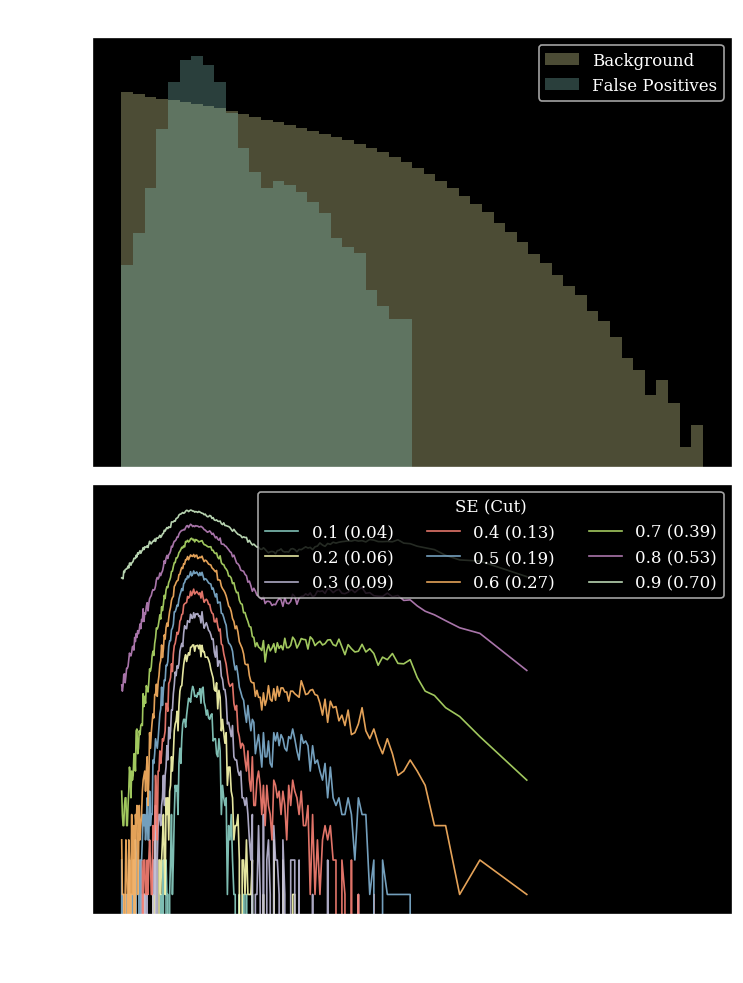

strength: 1, bins: 5
Entering Training...
Epoch:0001/0200  (9.3  s)
 Train: loss:0.3279, acc:53.1% || Val: loss: 0.0974, acc:80.5%, R50: 6.4930, 1/JSD: 105.4927


KeyboardInterrupt: 

In [6]:
# OG
jsdR50flatstr = []
for i,frac in enumerate([1,20,45,75,100,125,200,500,1000,1500]):
    for bins in [5,20,50,100]:
        torch.manual_seed(777)
        for j in range(10):
            print(f"strength: {frac}, bins: {bins}")
            metrics_train_L = Metrics()
            metrics_val_L = Metrics(validation=True)

            model_L = Model().to(device)
            optimizer = torch.optim.Adam(model_L.parameters(),lr=1e-3,)
            scheduler = MultiStepLR(optimizer,milestones=[100,150],gamma=0.1)
            loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=2,bins=bins,memory=False,order=0)
            log=Logger(path+f"MoDe(f{frac}b{bins})-{j}.txt")
            model_L.fit(traindataset=traindataset,
                        valdataset=valdataset,
                        optimizer=optimizer,
                        loss=loss,
                        **params,
                        log=log,
                      #scheduler=scheduler,
                      metrics=[metrics_train_L,metrics_val_L])
            torch.save(model_L.state_dict(),path+f"MoDe(f{frac}b{bins})-{j}.pt")
            model_L.train(False)
            out=plot_stuff(model=model_L,name=f"MoDe str:{frac}, bins:{bins}-{j}",X=X,
                   y=test_labels,x_biased=test[:,0],mbins=200,histbins=50,scale="log",
                           f=path+f"MoDe(f{frac}b{bins})-{j}.png")
            jsdR50flatstr.append(out)

strength: 1000 - 0
Entering Training...
Epoch:0001/0200  (11.2 s)
 Train: loss:319.0598, acc:30.5% || Val: loss: 0.0983, acc:77.8%, R50: 1.6651, 1/JSD: 237.2553
Epoch:0010/0200  (49.7 s)
 Train: loss:158.3453, acc:29.5% || Val: loss: 0.0987, acc:80.1%, R50: 1.5314, 1/JSD: 767.7894
Epoch:0020/0200  (92.5 s)
 Train: loss:96.8105, acc:29.9% || Val: loss: 0.0991, acc:80.1%, R50: 2.7060, 1/JSD: 216.6237
Epoch:0030/0200  (135.4s)
 Train: loss:116.1689, acc:30.3% || Val: loss: 0.0998, acc:80.3%, R50: 3.5902, 1/JSD: 16.7743
Epoch:0040/0200  (177.8s)
 Train: loss:117.5609, acc:30.5% || Val: loss: 0.1009, acc:80.3%, R50: 3.6205, 1/JSD: 142.0821
Epoch:0050/0200  (220.3s)
 Train: loss:112.7602, acc:30.3% || Val: loss: 0.1027, acc:80.2%, R50: 2.2636, 1/JSD: 2813.0594
Epoch:0060/0200  (262.5s)
 Train: loss:121.5263, acc:30.8% || Val: loss: 0.1042, acc:80.2%, R50: 2.1565, 1/JSD: 1821.9981
Epoch:0070/0200  (304.9s)
 Train: loss:118.9278, acc:31.3% || Val: loss: 0.1061, acc:80.2%, R50: 1.3722, 1/JSD: 2

/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


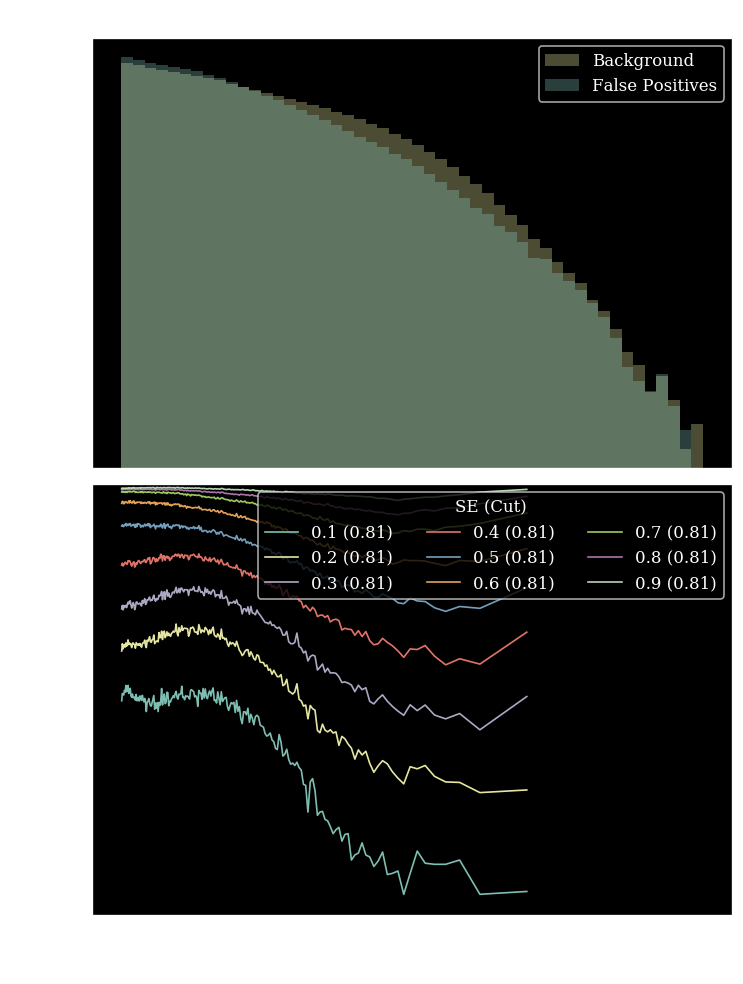

strength: 1000 - 1
Entering Training...
Epoch:0001/0200  (11.5 s)
 Train: loss:322.2054, acc:30.6% || Val: loss: 0.0986, acc:79.0%, R50: 1.5300, 1/JSD: 1289.7916
Epoch:0010/0200  (50.7 s)
 Train: loss:151.0382, acc:30.6% || Val: loss: 0.0989, acc:80.0%, R50: 1.5282, 1/JSD: 91.1633
Epoch:0020/0200  (93.9 s)
 Train: loss:110.4074, acc:30.8% || Val: loss: 0.0996, acc:79.9%, R50: 2.0172, 1/JSD: 1299.4152
Epoch:0030/0200  (136.6s)
 Train: loss:109.7834, acc:31.4% || Val: loss: 0.1001, acc:80.3%, R50: 1.7855, 1/JSD: 173.6335
Epoch:0040/0200  (179.5s)
 Train: loss:126.3919, acc:29.5% || Val: loss: 0.1014, acc:80.2%, R50: 1.6261, 1/JSD: 251.4924


Exception ignored in: <function _releaseLock at 0x7fe842ab66a8>
Traceback (most recent call last):
  File "/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


RuntimeError: DataLoader worker (pid(s) 7450) exited unexpectedly

In [8]:
# OG
jsdR50disco = []
for i,frac in enumerate([1000]):
    torch.manual_seed(777)
    for j in range(10):
        print(f"strength: {frac} - {j}")
        metrics_train_L = Metrics()
        metrics_val_L = Metrics(validation=True)
        model_L = Model().to(device)
        optimizer = torch.optim.Adam(model_L.parameters(),lr=1e-4,)
        scheduler = MultiStepLR(optimizer,milestones=[100,150],gamma=0.1)
        loss =  Disco(frac=frac,labels=traindataset.labels,background_only=True)
        log=Logger(path+f"DisCo(f{frac})-{j}.txt")
        model_L.fit(traindataset=traindataset,
                    valdataset=valdataset,
                    optimizer=optimizer,
                    loss=loss,
                    **params,
                    log=log,
                  #scheduler=scheduler,
                  metrics=[metrics_train_L,metrics_val_L])
        torch.save(model_L.state_dict(),path+f"DisCo(f{frac})-{j}.pt")
        model_L.train(False)
        out=plot_stuff(model=model_L,name=f"DisCo str:{frac} - {j}",X=X,
               y=test_labels,x_biased=test[:,0],mbins=200,histbins=50,scale="log",
                       f=path+f"DisCo(f{frac})-{j}.png")
        jsdR50disco.append(out)
with open(path+"DisCoSummary.txt",'w') as f:
    f.writelines([str(x)[1:-1]+"\n" for x in jsdR50disco])

In [ ]:
# DisCo
jsdR50disco = []
for i,frac in enumerate([1,20,45,75,100,125,200,500,1000,1500]):
    for bins in [5,20,50,100]:
        torch.manual_seed(777)
        for j in range(10):
            print(f"strength: {frac}, bins: {bins}")
            metrics_train_L = Metrics2()
            metrics_val_L = Metrics2(validation=True)

            model_L = Model().to(device)
            optimizer = torch.optim.Adam(model_L.parameters(),lr=1e-3,)
            scheduler = MultiStepLR(optimizer,milestones=[100,150],gamma=0.1)
            loss =  Disco(frac=frac,labels=traindataset.labels,background_only=True)
            log=Logger(path+f"DisCo(f{frac}b{bins})-{j}.txt")
            model_L.fit(traindataset=traindataset,
                        valdataset=valdataset,
                        optimizer=optimizer,
                        loss=loss,
                        **params,
                        log=log,
                      #scheduler=scheduler,
                      metrics=[metrics_train_L,metrics_val_L])
            torch.save(model_L.state_dict(),path+f"DisCo(f{frac}b{bins})-{j}.pt")
            model_L.train(False)
            out=plot_stuff(model=model_L,name=f"DisCo str:{frac}, bins:{bins}-{j}",X=X,
                   y=test_labels,x_biased=test[:,0],mbins=200,histbins=50,scale="log",
                           f=path+f"DisCo(f{frac}b{bins})-{j}.png")
            jsdR50disco.append(out)

Text(0.5, 1.0, '8192(1) batch size')

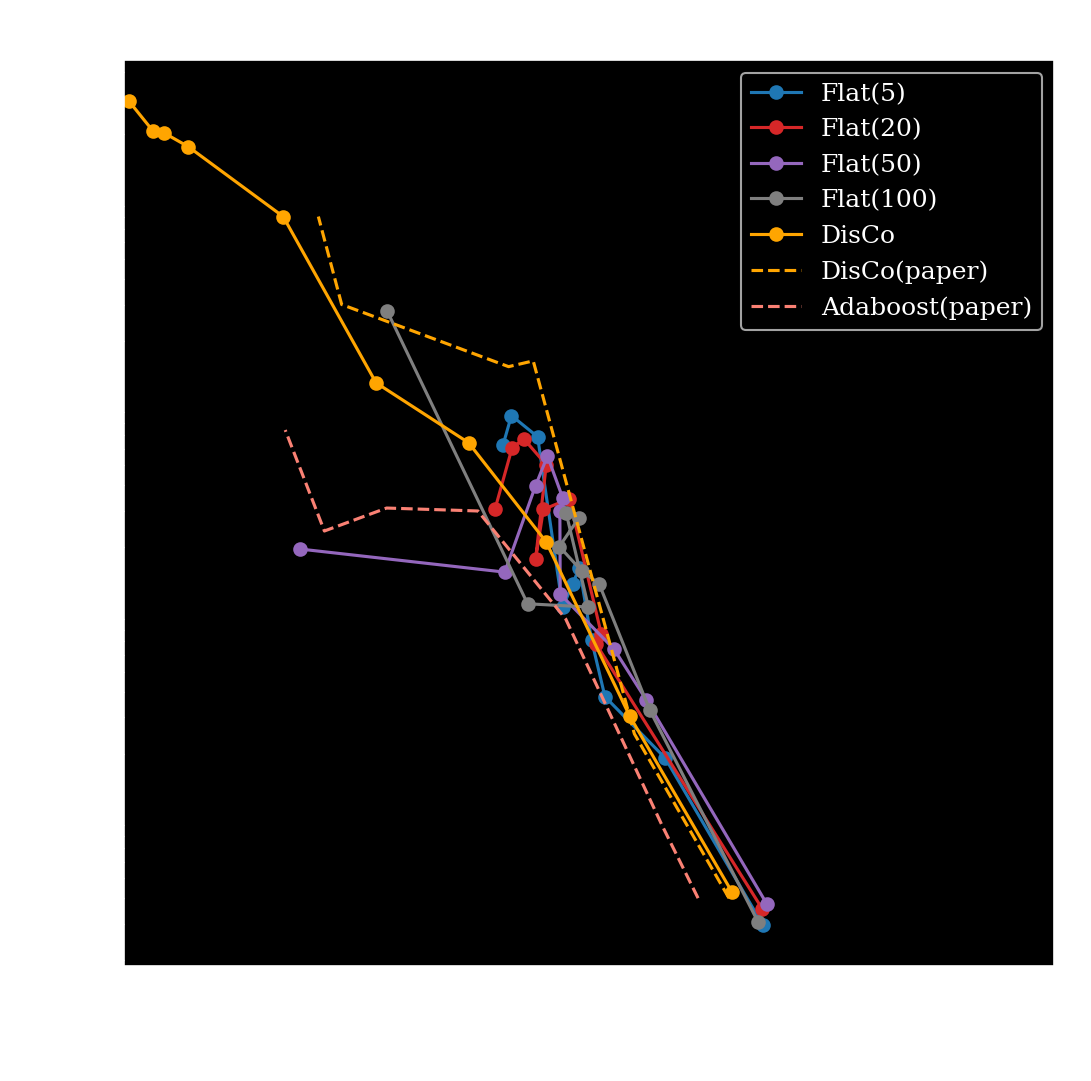

In [18]:
JSD,R50 = zip(*jsdR50flatstr[0::4])
JSDa,R50a = zip(*jsdR50flatstr[1::4])
JSDb,R50b = zip(*jsdR50flatstr[2::4])
JSDc,R50c = zip(*jsdR50flatstr[3::4])
JSD2,R502 = zip(*jsdR50Disco)
JSD3 = np.array([4,25,1.6e3,1.5e3,3e3,8e3])
R503 = [23,15,9.5,8.5,4,3.6]
JSD4 = [4,9,90,300,310,240,740]
R504 = [20,17,11,7.4,4.9,3.7,3.1]
    
fig, ax= plt.subplots(1,1,figsize=(8,8),dpi=150)
plt.errorbar(R50,JSD,fmt='-o',label='Flat(5)',c='tab:blue')
plt.errorbar(R50a,JSDa,fmt='-o',label='Flat(20)',c='tab:red')
plt.errorbar(R50b,JSDb,fmt='-o',label='Flat(50)',c='tab:purple')
plt.errorbar(R50c,JSDc,fmt='-o',label='Flat(100)',c='tab:gray')
plt.errorbar(R502,np.array(JSD2),fmt='-o',label='DisCo',c='orange')
plt.errorbar(R503,JSD3,fmt='--',label='DisCo(paper)',c='orange',ls='--')
plt.errorbar(R504,JSD4,fmt='--',label='Adaboost(paper)',c='C3',ls='--')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1.5,100])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.ylim([1,1.3e5])
plt.legend(loc='upper right',fontsize=12)
plt.xlabel('R50',fontsize=20)
plt.ylabel('1/JSD',fontsize=20)
plt.title("8192(1) batch size",fontsize=20)
#fig.savefig(f"./logs/new/8192(1)/PhaseSpace.png")